<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DBSCAN vs. K-Means

_Author: Katie Sylvia_
 
 In **Unsupervised Learning** we have different type of algorithms such as:
 
1. Clustering
2. PCA
2. Association Rules
3. Recommendation Engines


In **Clustering** we have talked about:
1. K-Means Clustering
2. DBSCAN Clustering

In this notebook, we will mainly discuss *DBSCAN Clustering*

As you recall from yesterday, there are some disadvantages in K-Means Clustering. Among them are that K-Means is sensitive to outliers and does not perform well with non-spherical shapes of clusters.
   
   To deal with this we have *Density Based Spatial Clustering (DBSCAN)*:
   
     - It is mainly used to find outliers and to deal with non-spherical data
     - Clustering is mainly done based on density of data points (where more number of data points are present).


In [2]:
# Something new to install...
! pip install plotly

In [3]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Something new to import...
import plotly.express as px

# Imports from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, KMeans

# Setting formatting of floats to be five places past the decimal
pd.options.display.float_format = '{:.5f}'.format

### I. Get Data Ready

In [5]:
# From Plotly, we'll import the Gapminder data
df = px.data.gapminder()

In [6]:
# Head
df.head()

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,28.80100,8425333,779.44531,AFG,4
1,Afghanistan,Asia,1957,30.33200,9240934,820.85303,AFG,4
2,Afghanistan,Asia,1962,31.99700,10267083,853.10071,AFG,4
3,Afghanistan,Asia,1967,34.02000,11537966,836.19714,AFG,4
4,Afghanistan,Asia,1972,36.08800,13079460,739.98111,AFG,4


In [7]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    1704 non-null   object 
 1   continent  1704 non-null   object 
 2   year       1704 non-null   int64  
 3   lifeExp    1704 non-null   float64
 4   pop        1704 non-null   int64  
 5   gdpPercap  1704 non-null   float64
 6   iso_alpha  1704 non-null   object 
 7   iso_num    1704 non-null   int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 106.6+ KB


In [8]:
# Nulls
df.isnull().sum()

country      0
continent    0
year         0
lifeExp      0
pop          0
gdpPercap    0
iso_alpha    0
iso_num      0
dtype: int64

In [9]:
# Filter Data to Most Recent Year
df.sort_values(by = 'year', ascending = False,inplace=True)
df = df[df['year'] == 2007]
df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
1703,Zimbabwe,Africa,2007,43.48700,12311143,469.70930,ZWE,716
491,Equatorial Guinea,Africa,2007,51.57900,551201,12154.08975,GNQ,226
515,Ethiopia,Africa,2007,52.94700,76511887,690.80558,ETH,231
527,Finland,Europe,2007,79.31300,5238460,33207.08440,FIN,246
539,France,Europe,2007,80.65700,61083916,30470.01670,FRA,250
...,...,...,...,...,...,...,...,...
71,Australia,Oceania,2007,81.23500,20434176,34435.36744,AUS,36
83,Austria,Europe,2007,79.82900,8199783,36126.49270,AUT,40
107,Bangladesh,Asia,2007,64.06200,150448339,1391.25379,BGD,50
23,Albania,Europe,2007,76.42300,3600523,5937.02953,ALB,8


In [10]:
# Set Country to Index
df.set_index('country',inplace=True)

In [11]:
# Drop `iso_alpha`, `year`, and `iso_num`
df.drop(columns=['iso_alpha', 'year', 'iso_num'],inplace=True)

In [12]:
# How many countries in each continent?
df.value_counts('continent')

continent
Africa      52
Asia        33
Europe      30
Americas    25
Oceania      2
Name: count, dtype: int64

In [13]:
# Get dummies!
df = pd.get_dummies(df, columns=['continent'])

In [14]:
# Head (again!)
df.head()

,lifeExp,pop,gdpPercap,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
country,,,,,,,,
Zimbabwe,43.48700,12311143,469.70930,True,False,False,False,False
Equatorial Guinea,51.57900,551201,12154.08975,True,False,False,False,False
Ethiopia,52.94700,76511887,690.80558,True,False,False,False,False
Finland,79.31300,5238460,33207.08440,False,False,False,True,False
France,80.65700,61083916,30470.01670,False,False,False,True,False


In [15]:
# Define X
X = df[['lifeExp', 'pop', 'gdpPercap', 'continent_Africa', 'continent_Americas',
       'continent_Asia', 'continent_Europe', 'continent_Oceania']]

In [16]:
# Scale Features
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### II. K-Means Clustering Model

In [18]:
# Elbow Plot
inertia_list = []

for k in range(1, 21):
    km = KMeans(n_clusters=k, random_state=42) 
    km.fit(X_sc)                           
    inertia_list.append(km.inertia_)          

inertia_list

[1135.9999999999998,
 833.8811209096407,
 594.6936247575941,
 411.73669924060425,
 265.07270100352315,
 145.18140361023723,
 107.71312813400928,
 86.88065308503914,
 64.21503964722274,
 51.11763019162191,
 46.55267688875324,
 39.935880826346306,
 35.093663726634716,
 34.0778265329334,
 31.888426503692855,
 30.63096274814354,
 28.978499048985796,
 26.14479937735718,
 25.279823980134097,
 23.469275153097882]

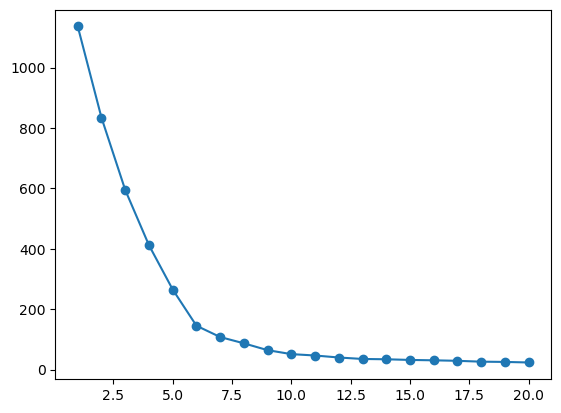

In [19]:
plt.plot(range (1,21),inertia_list,marker='o');

In [20]:
# Silhouette Score

silhouette_list = []

for k in range(2, 21):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_sc)
    silhouette_list .append(silhouette_score(X_sc, km.labels_))

silhouette_list 

[0.35297153466005493,
 0.49157764889142086,
 0.6190518825966603,
 0.6533518645117282,
 0.6841362868735931,
 0.6788030429382466,
 0.6694268365333834,
 0.611564034924892,
 0.611036290859275,
 0.600274049284114,
 0.5596168962443392,
 0.5346330830663086,
 0.5173684660021534,
 0.5395261248458775,
 0.52864716818311,
 0.47492998267768255,
 0.4741915962746897,
 0.4607625427075435,
 0.45836313687921104]

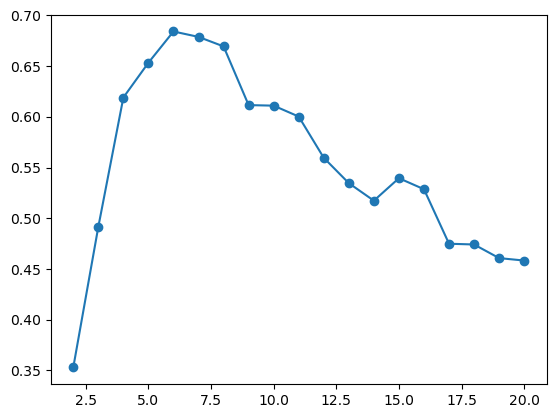

In [21]:
plt.plot(range (2,21),silhouette_list,marker='o');

#### Based off of our metrics above, which k should we try first?

Answer Here: k=6 with the highest score



In [154]:
# Now let's try it!
# Instantiate & Fit
km = KMeans(n_clusters=6, random_state=42)
km.fit(X_sc)

KMeans(n_clusters=6, random_state=42)

#### Visualize Your Clusters!

In [27]:
# Add cluster column
km.labels_
df['cluster'] = km.labels_
df.head()

,lifeExp,pop,gdpPercap,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania,cluster
country,,,,,,,,,
Zimbabwe,43.48700,12311143,469.70930,True,False,False,False,False,0
Equatorial Guinea,51.57900,551201,12154.08975,True,False,False,False,False,0
Ethiopia,52.94700,76511887,690.80558,True,False,False,False,False,0
Finland,79.31300,5238460,33207.08440,False,False,False,True,False,1
France,80.65700,61083916,30470.01670,False,False,False,True,False,1


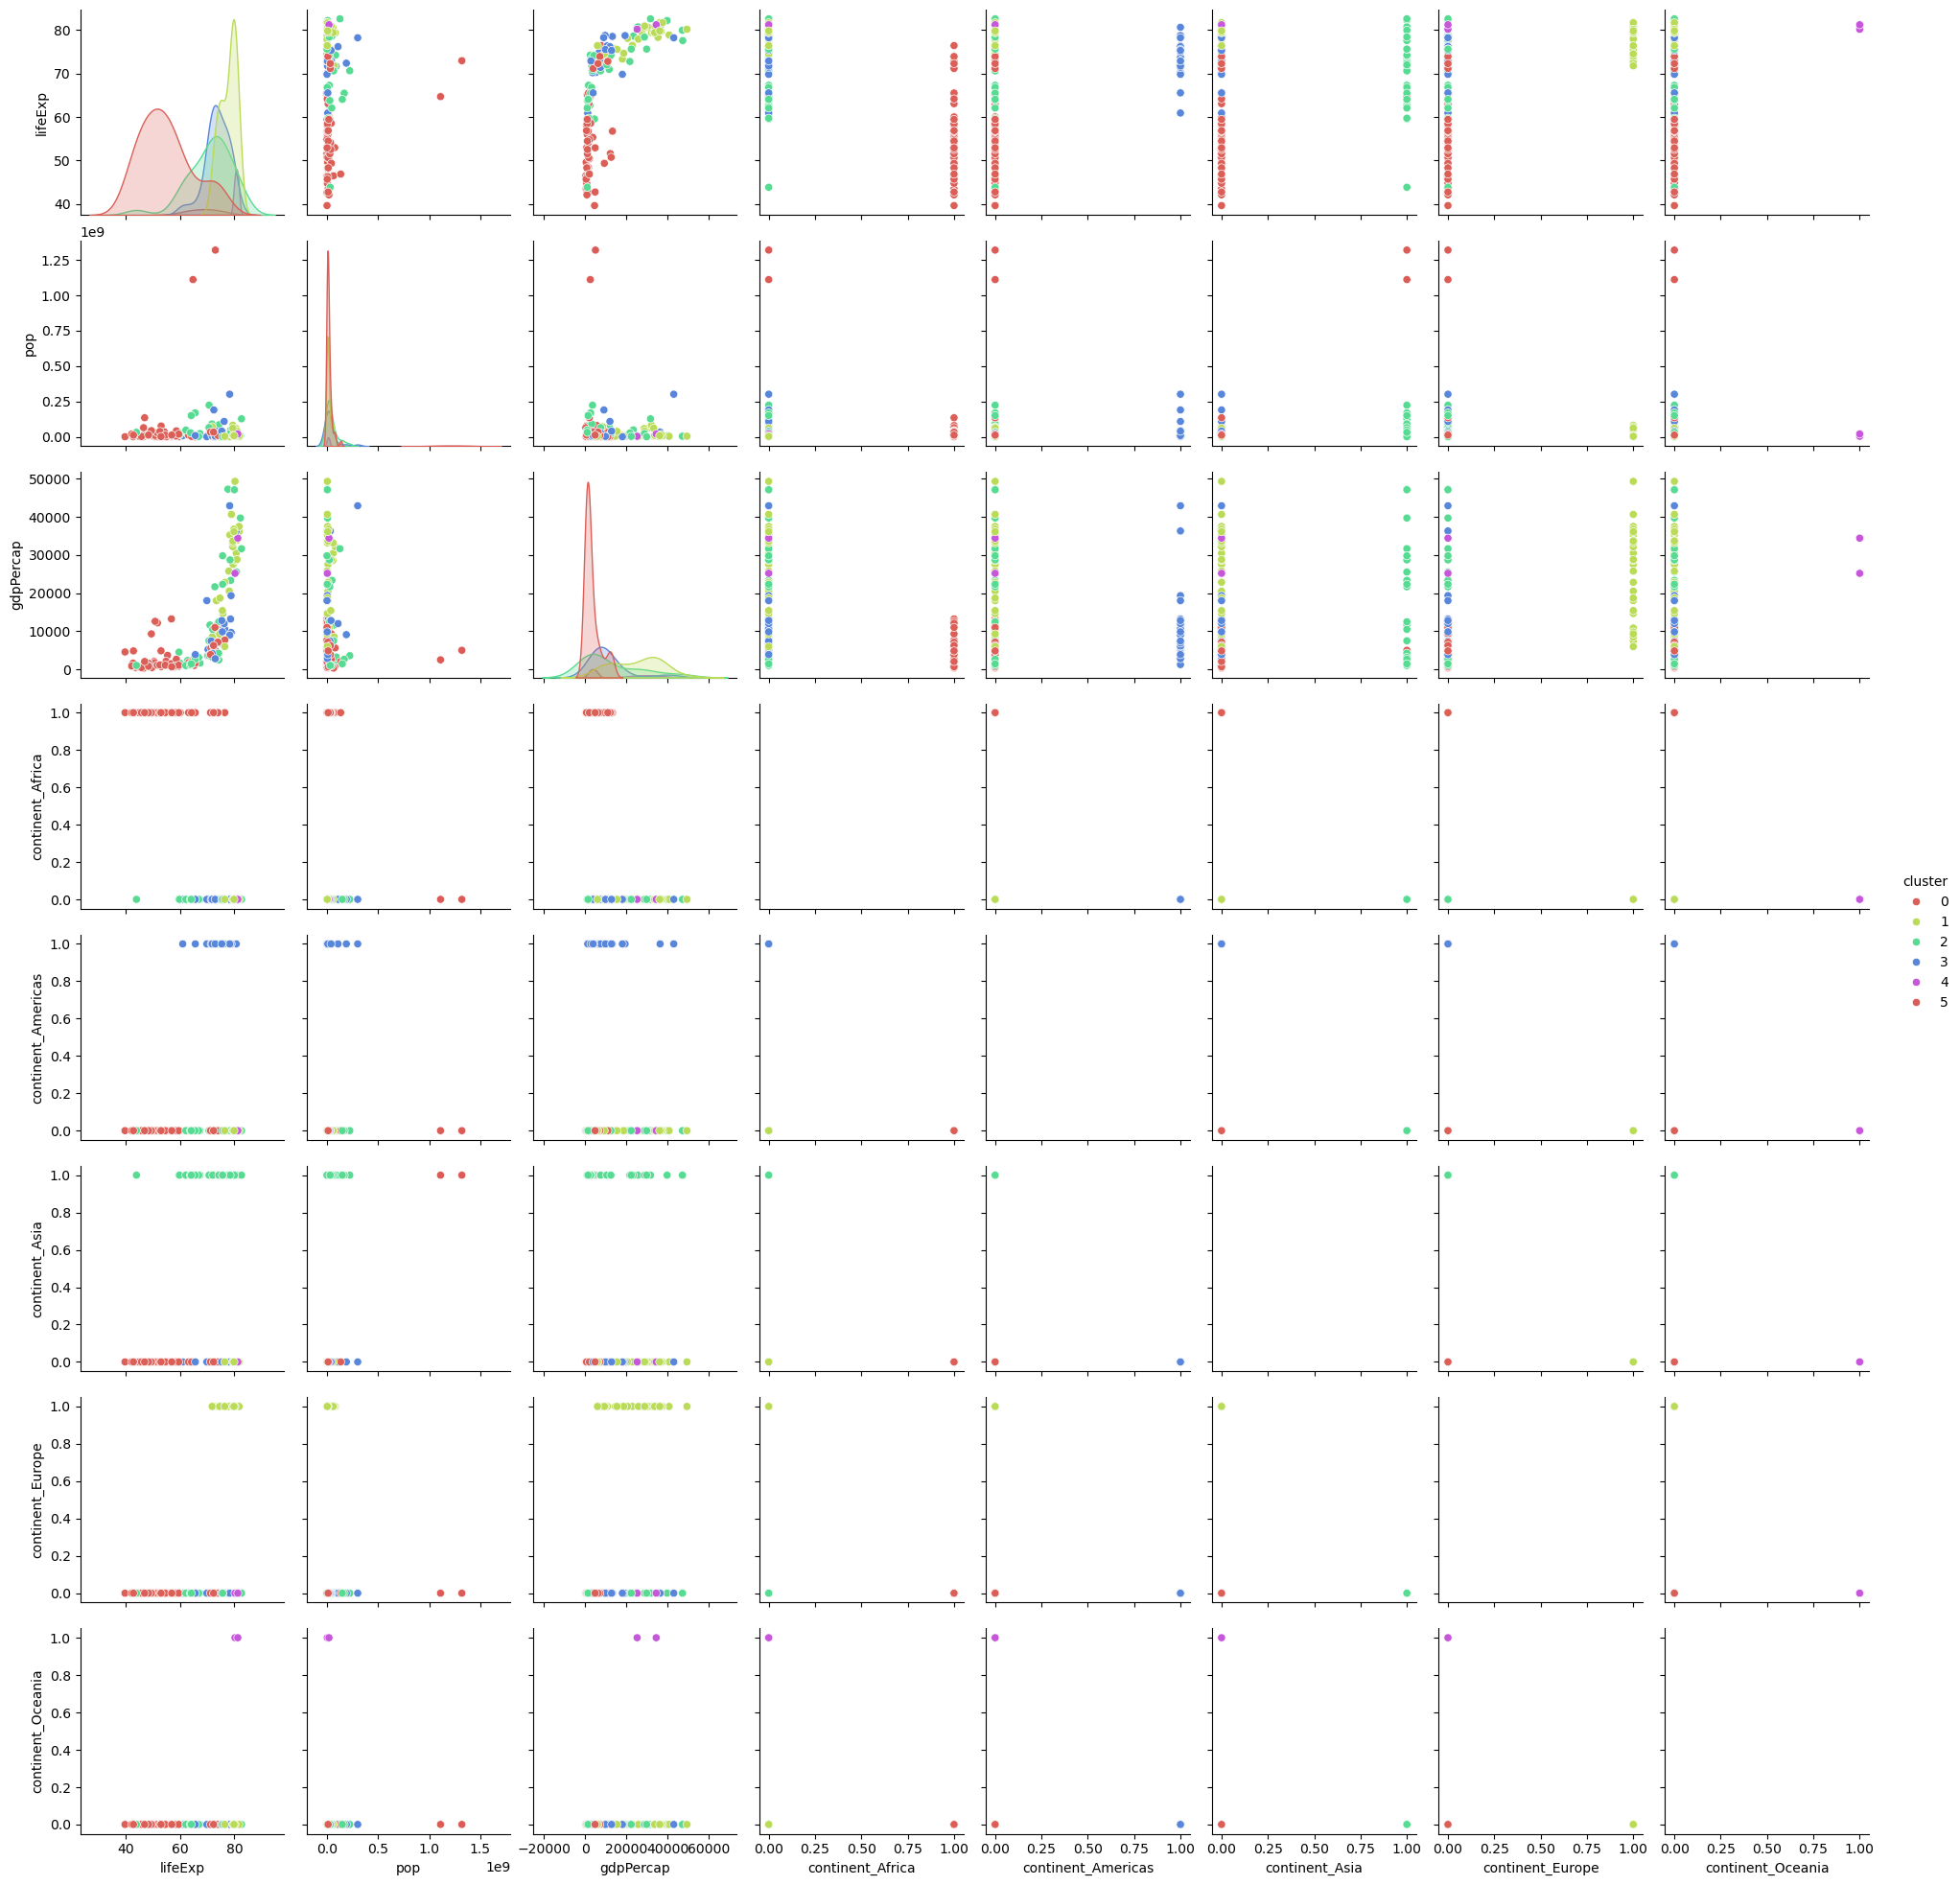

In [28]:
# Method 1: Pairplots
sns.pairplot(df, hue='cluster', palette='hls', diag_kind='kde')
plt.show()

In [29]:
# Method 2: Groupby
df.groupby('cluster').mean(numeric_only=True)

,lifeExp,pop,gdpPercap,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
cluster,,,,,,,,
0,54.80604,17875763.30769,3089.03260,1.00000,0.00000,0.00000,0.00000,0.00000
1,77.64860,19536617.63333,25054.48164,0.00000,0.00000,0.00000,1.00000,0.00000
2,70.85100,44608851.61290,13038.66327,0.00000,0.00000,1.00000,0.00000,0.00000
3,73.60812,35954847.36000,11003.03163,0.00000,1.00000,0.00000,0.00000,0.00000
4,80.71950,12274973.50000,29810.18827,0.00000,0.00000,0.00000,0.00000,1.00000
5,68.82950,1214539713.50000,3705.66263,0.00000,0.00000,1.00000,0.00000,0.00000


In [156]:
pd.Series(dbscan.labels_).value_counts()

 0    52
 2    31
 1    30
 3    25
-1     4
Name: count, dtype: int64

#### An Even Closer Look...Which countries are in each of these clusters?

In [158]:
# For loop
for cluster_num in df['cluster'].unique():
    print(f"Countries in Cluster {cluster_num}:")
    countries_in_cluster = df[df['cluster'] == cluster_num].index.tolist()

    # Print
    print(countries_in_cluster)
    print() 

Countries in Cluster 0:
['Zimbabwe', 'Equatorial Guinea', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Eritrea', 'Egypt', 'Zambia', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Djibouti', 'Benin', 'Reunion', 'Rwanda', 'Sao Tome and Principe', 'Uganda', 'Senegal', 'Sierra Leone', 'Somalia', 'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Tunisia', 'Algeria', 'Angola']

Countries in Cluster 1:
['Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Portugal', 'Romania', 'Serbia', 'Slovak Republic', 'Slovenia', 'Spain', 'Turkey', 'Sweden', 'Switzerland', 'Poland', 'Montenegro', 'Netherlands', 

### III. [In Groups] DBSCAN Clustering Model

- Try tuning your parameters
- Visualize your clusters
- Determine your best silhouette score
- Is this better or worse than KMeans?
- Which countries are in each cluster?

In [160]:
dbscan = DBSCAN(eps=2.5, min_samples=4)
dbscan.fit(X_sc)

DBSCAN(eps=2.5, min_samples=4)

In [162]:
pd.Series(dbscan.labels_).value_counts()

 0    52
 2    31
 1    30
 3    25
-1     4
Name: count, dtype: int64

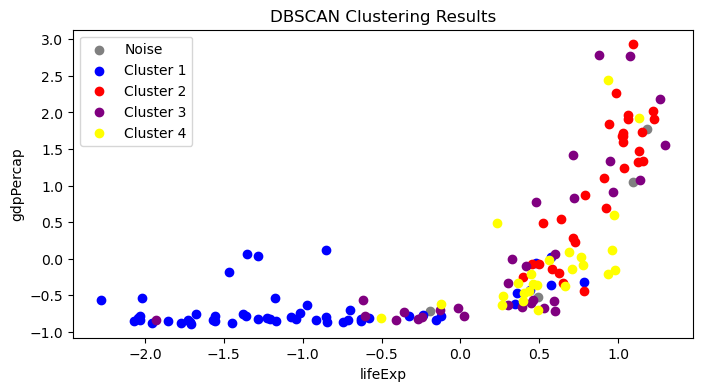

In [186]:
plt.figure(figsize=(8, 4))

colors = {-1: 'grey', 0: 'blue', 1: 'red', 2: 'purple', 3: 'yellow'}  # Color map for each label
labels = {-1: 'Noise', 0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4'}  # Legend labels

for label, color in colors.items():  
    mask = dbscan.labels_ == label  
    plt.scatter(X_sc[mask, 0], X_sc[mask, 2], c=color, label=labels[label])

plt.title('DBSCAN Clustering Results')
plt.xlabel('lifeExp')
plt.ylabel('gdpPercap')
plt.legend()
plt.show()

In [168]:
silhouette_score(X_sc,dbscan.labels_)

0.6773539240711308

In [172]:
print(f'K-Means Silhouette score:{silhouette_score(X_sc,km.labels_):.4f}')
print(f'DBSCAN Silhouette score:{silhouette_score(X_sc,dbscan.labels_):.4f}')

K-Means Silhouette score:0.7011
DBSCAN Silhouette score:0.6774


In [184]:
df['dbscan_cluster'] = dbscan.labels_
for cluster_num in df['dbscan_cluster'].unique():
    print(f"Countries in Cluster {cluster_num}:")
    
    # Countries belonging to the current cluster
    countries_in_cluster = df[df['dbscan_cluster'] == cluster_num].index.tolist()
    
    # Print the countries
    print(countries_in_cluster)
    print() 

Countries in Cluster 0:
['Zimbabwe', 'Equatorial Guinea', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Eritrea', 'Egypt', 'Zambia', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Djibouti', 'Benin', 'Reunion', 'Rwanda', 'Sao Tome and Principe', 'Uganda', 'Senegal', 'Sierra Leone', 'Somalia', 'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Tunisia', 'Algeria', 'Angola']

Countries in Cluster 1:
['Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Portugal', 'Romania', 'Serbia', 'Slovak Republic', 'Slovenia', 'Spain', 'Turkey', 'Sweden', 'Switzerland', 'Poland', 'Montenegro', 'Netherlands', 

### ⭐ There are pros & cons for both DBSCAN and K-Means Clustering Models. Again, since this is unsupervised it is not easy to know which method you should use until you dive into your data! Keep exploring and diving into your data 💫 